In [1]:
import matplotlib as mpl
mpl.rcParams.update({'font.size': 12})
mpl.rcParams['axes.formatter.useoffset'] = False

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np


In [2]:
import utils.load_grid as lg
import utils.feathers
from proteus.config import read_config
from proteus.utils.plot import get_colour

In [3]:
%matplotlib inline
# %config InlineBackend.figure_format='retina'
# %matplotlib widget

In [4]:
pgrid_dir = "data/scratch/l98d_habrok2/"
cases = lg.get_cases(pgrid_dir, only_completed=True)
ncases = len(cases)

cnums = [int(s.split("_")[-1]) for s in cases]
stts = lg.get_statuses(pgrid_dir)
helps, hvars = lg.load_helpfiles(cases)

confs = []
for f in cases:
    confs.append( read_config(f+"/init_coupler.toml") )

age_start = float(helps[0]["age_star"].iloc[0])

print("Done")

Helpfiles: 100%|██████████| 523/523 [00:08<00:00, 59.63it/s]


Done


### Make plots

In [15]:
case = 670

In [16]:
idx = cnums.index(case)

print(lg.descend_get(confs[idx],"params.out.path"))
print(lg.descend_get(confs[idx],"outgas.fO2_shift_IW"))

scratch/l98d_habrok2/case_00670/
0.0


In [17]:
print("Psurf = %.2f bar"%(helps[idx]["P_surf"].iloc[-1]))
print("rho = %.2f g/cc"%(helps[idx]["rho_obs"].iloc[-1]/1e3))

Psurf = 90196.83 bar
rho = 3.45 g/cc


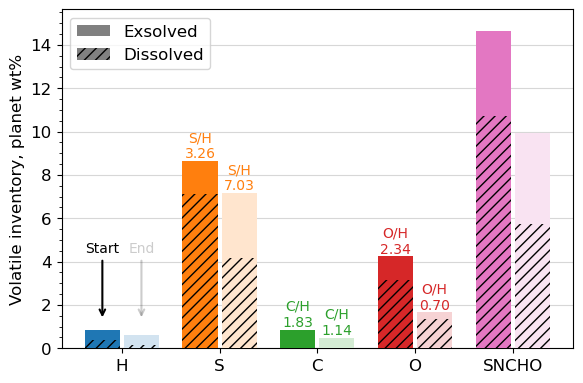

In [44]:
figscale = 1.1
fig, ax = plt.subplots(1,1, figsize=(6*figscale, 4*figscale))

elems = ['H', 'S', 'C',  'O']

dx = 2.5
dc = 1.0
bw = 0.9
ht = "///"

i0 = 5
i1 = -2

# totals
t_liq_0 = 0.0
t_atm_0 = 0.0
t_liq_1 = 0.0
t_atm_1 = 0.0

for i,e in enumerate(elems):

    col = "C"+str(i)
    al = 0.2

    # start of simulation
    yunit = helps[idx]["M_planet"].iloc[i0] / 100

    e_liq = helps[idx][e+"_kg_liquid"].iloc[i0] / yunit
    ax.bar(i*dx, e_liq,  color=col, hatch=ht, width=bw, zorder=5)
    t_liq_0 += e_liq

    e_atm = helps[idx][e+"_kg_atm"].iloc[i0] / yunit
    ax.bar(i*dx, e_atm, bottom=e_liq, color=col, width=bw, zorder=5)
    t_atm_0 += e_atm

    if e != 'H':
        XH = helps[idx][e+"_kg_atm"].iloc[i0] / helps[idx]["H_kg_atm"].iloc[i0]
        ax.text(i*dx, e_atm+e_liq, "%s/H\n%.2f"%(e,XH),
                    ha='center', va='bottom', fontsize=10, color=col, zorder=8)


    # end of simulation
    yunit = helps[idx]["M_planet"].iloc[i1] / 100

    e_liq = helps[idx][e+"_kg_liquid"].iloc[i1] / yunit
    ax.bar(i*dx+dc, e_liq,  color='w', width=bw, zorder=4)
    ax.bar(i*dx+dc, e_liq,  color=col, hatch=ht, alpha=al, width=bw, zorder=5)
    t_liq_1 += e_liq

    e_atm = helps[idx][e+"_kg_atm"].iloc[i1] / yunit
    ax.bar(i*dx+dc, e_atm, bottom=e_liq, color='w', width=bw, zorder=4)
    ax.bar(i*dx+dc, e_atm, bottom=e_liq, color=col, alpha=al, width=bw, zorder=5)
    t_atm_1 += e_atm

    if e != 'H':
        XH = helps[idx][e+"_kg_atm"].iloc[i1] / helps[idx]["H_kg_atm"].iloc[i1]
        ax.text(i*dx+dc, e_atm+e_liq, "%s/H\n%.2f"%(e,XH),
                    ha='center', va='bottom', fontsize=10, color=col, zorder=8)

# total
col = "tab:pink"
#   start
ax.bar(len(elems)*dx, t_liq_0,                    color=col, zorder=5, width=bw, hatch=ht)
ax.bar(len(elems)*dx, t_atm_0, bottom=t_liq_0,    color=col, zorder=5, width=bw)
#   end
ax.bar(len(elems)*dx+dc, t_liq_1,                 color='w', zorder=4, width=bw)
ax.bar(len(elems)*dx+dc, t_liq_1,                 color=col, zorder=5, width=bw, alpha=al, hatch=ht)
ax.bar(len(elems)*dx+dc, t_atm_1, bottom=t_liq_1, color='w', zorder=4, width=bw)
ax.bar(len(elems)*dx+dc, t_atm_1, bottom=t_liq_1, color=col, zorder=5, width=bw, alpha=al)

# legend
col = 'grey'
ax.bar([0],[0], color=col, label="Exsolved")
ax.bar([0],[0], color=col, hatch=ht, label="Dissolved")


# annotate
for d in zip(("Start","End"),(0,dc),(1,al)):

    yb = helps[idx]["H_kg_total"].iloc[i0] / helps[idx]["M_planet"].iloc[i0] * 100 * 1.5

    ax.annotate(d[0], xy=(d[1], yb), xytext=(d[1], yb+3),
            arrowprops=dict(arrowstyle="->", lw=1.5,alpha=d[2]),
            fontsize=10, ha='center', va='bottom', alpha=d[2])

# decorate
ax.set_xticks(np.arange(0,(len(elems)+1)*dx, dx)+dc/2)
ax.set_xticklabels(elems + ["SNCHO"])
ax.set_ylabel("Volatile inventory, planet wt%")
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.5))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
ax.grid(axis='y', zorder=-2, alpha=0.5)
ax.set_ylim(bottom=0,top=t_atm_0+t_liq_0+1)

ax.legend()

plt.show()
fig.savefig("output/fig_inventory.pdf", bbox_inches='tight', dpi=300)